In [59]:
%matplotlib widget

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import circmean, circvar
from matplotlib.animation import FuncAnimation

import seaborn as sns

from matplotlib import rc
import yaml
import os

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5') # conda create -n newenv -c conda-forge ffmpeg

with open("cal-settings.yml", 'r') as file:
    vars = yaml.safe_load(file)
    RX_TX_SAME_CHANNEL = vars["RX_TX_SAME_CHANNEL"]

print("Cable connections")
if RX_TX_SAME_CHANNEL:
    REF_RX_CH = FREE_TX_CH = 0
    LOOPBACK_RX_CH = LOOPBACK_TX_CH = 1
    print("\nPLL REF-->CH0 RX\nCH1 TX-->CH1 RX\nCH0 TX -->")
else:
    LOOPBACK_RX_CH = FREE_TX_CH = 0
    REF_RX_CH = LOOPBACK_TX_CH = 1
    print("\nPLL REF-->CH1 RX\nCH1 TX-->CH0 RX\nCH0 TX -->")

loopback_rx = f"rx_ch{LOOPBACK_RX_CH}"

Cable connections

PLL REF-->CH1 RX
CH1 TX-->CH0 RX
CH0 TX -->


In [60]:


usrp1_file = f'data_T03_20240529081538.txt'

usrp2_file = f'data_T04_20240529081753.txt'

In [61]:
# wrap around function which "glues" together 0 and 360 degrees.

def wraparound(arr):
    arr = np.asarray(arr)
    fltr = arr > 180
    arr[fltr] = arr[fltr] - 360
    return arr

In [62]:
fields = ["meas_id", "hostname", "meas_type",
          "tx_ch0", "tx_ch1", "rx_ch0", "rx_ch1", "_0", "_1"]

df1 = pd.read_csv(usrp1_file,
                  names=fields, header=None, sep=';')

df2 = pd.read_csv(usrp2_file,
                  names=fields, header=None, sep=';')


# given that we meanly want to plot things, shift the radians to degrees and wrap around
for frame in [df1, df2]:
    for col in ["tx_ch0", "tx_ch1", "rx_ch0", "rx_ch1"]:
        frame.loc[:, col] = wraparound(np.rad2deg(frame[col]))
        
# clean up
df1.drop(columns=["_0", "_1"], inplace=True)
df2.drop(columns=["_0", "_1"], inplace=True)


fltr_lb_df1 = df1['meas_type'] == "LB"
fltr_lb_df2 = df2['meas_type'] == "LB"

Check the absolute measured loopback check per USRP. This means read the measured phase after the first phase calibration (i.e., transmitting with $-(\phi_{rx}+\phi_{tx})$).

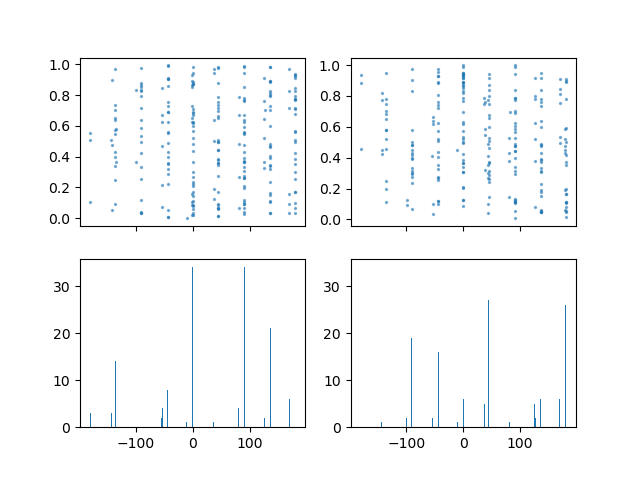

In [63]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True)

resolution = 1

x_df1 = df1.where(fltr_lb_df1).loc[:, loopback_rx].values
y_df1 = np.ones_like(x_df1) * np.random.random(len(x_df1)) # spread them random over [0,1.0)

x_df2 = df1.where(fltr_lb_df2).loc[:, loopback_rx].values
y_df2 = np.ones_like(x_df2) * np.random.random(len(x_df2)) # spread them random over [0,1.0)

axes[0,0].scatter(x_df1, y_df1, s=2, alpha=0.5);
axes[0,1].scatter(x_df2, y_df2, s=2, alpha=0.5);


x_df1 = df1.where(fltr_lb_df1).loc[:, loopback_rx].values


x_df2 = df1.where(fltr_lb_df2).loc[:, loopback_rx].values


axes[1, 0].hist(x_df1, bins=360//resolution)
axes[1, 1].hist(x_df2, bins=360//resolution);